# Pool Detection

## Install libs

In [116]:
import random
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import numpy as np
import glob
import os

# ========================================
# CONFIGURAÇÕES
# ========================================

N_AMOSTRAS_TOTAL = 1000
GRID_SPACING_METERS = 300  # Espaçamento do grid 
crs_proj = "EPSG:31983"  # UTM Zone 23S (metros)
crs_geo = "EPSG:4674"   # SIRGAS 2000 (Lat/Lon)

print("="*60)
print("AMOSTRAGEM DE PISCINAS - SÃO PAULO")
print("="*60)

AMOSTRAGEM DE PISCINAS - SÃO PAULO


## Downloading shapes of districts in São Paulo
### Access the link: 
**Link: https://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx**

Access the link and go to “**File Download**” located in the menu on the left side of the page.

Then select **Administrative Boundaries**, followed by **Districts**, and download the **Shapefile**.

### Loading file with districts of São Paulo

In [246]:
print("\nLoading file with districts of São Paulo...")
sp_districts = gpd.read_file("../data/district_map/SIRGAS_SHP_distrito.shp")
sp_districts = sp_districts.set_crs(crs_proj, allow_override=True)
print(f"✓ {len(sp_districts)} loaded districts")



Loading file with districts of São Paulo...
✓ 96 loaded districts


## Downloading shapes of residential areas in São Paulo
### I downloaded the zip file with the marked shapes directly from the São Paulo City Hall website:
**Link: https://gestaourbana.prefeitura.sp.gov.br/marco-regulatorio/zoneamento/arquivos/**

Access the link, go to “**General Zoning Map – Map 1**” and download the **SHP**.

After that, I put the folder inside the project (preferably in the data folder, without changing the file names) and deleted the points I didn't need to save space, leaving only **ZPR, ZER, ZM, ZCOR, ZEIS, ZEMP**, and **ZMIS_u (delete ZMIS_a)**.

In [130]:
data_dir = "../data/Mapa-1-SHP/ShapeCom_Vetos/"

prefixos_residenciais = ['ZPR', 'ZER', 'ZM', 'ZCOR', 'ZEIS', 'ZEMP', 'ZMIS']

print("\nLoading residential areas...")
lista_de_gdfs = []
all_shapefiles = glob.glob(os.path.join(data_dir, "*.shp"))

for f_path in all_shapefiles:
    filename = os.path.basename(f_path)
    
    if any(filename.startswith(prefixo) for prefixo in prefixos_residenciais):
        try:
            gdf = gpd.read_file(f_path)
            gdf.geometry = gdf.geometry.buffer(0)
            gdf['NOME_ZONA'] = filename.split('.')[0]
            lista_de_gdfs.append(gdf)
            print(f"  ✓ {filename}")
        except Exception as e:
            print(f"  ✗ {filename}: {e}")

if not lista_de_gdfs:
    raise Exception("ERROR: No residential shapefile found!")

zonas_alvo = pd.concat(lista_de_gdfs)
zonas_alvo = zonas_alvo.to_crs(crs_proj)
print(f"✓ {len(zonas_alvo)} combined residential polygons")


Carregando zonas residenciais...
  ✓ ZCOR_1.shp
  ✓ ZCOR_2.shp
  ✓ ZCOR_3.shp
  ✓ ZCOR_a.shp
  ✓ ZEIS_1.shp
  ✓ ZEIS_2.shp
  ✓ ZEIS_3.shp
  ✓ ZEIS_4.shp
  ✗ ZEIS_5.shp: IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
  ✓ ZEMP.shp
  ✓ ZER_1.shp
  ✓ ZER_2.shp
  ✓ ZER_a.shp
  ✓ ZMIS_u.shp
  ✓ ZM_a.shp
  ✓ ZM_u.shp
  ✓ ZPR.shp
✓ 30797 polígonos residenciais combinados


### Spatial Intersection: District x Zones

In [247]:
print("\nCalculating intersection (may take a while)...")
areas_de_amostragem = gpd.overlay(sp_districts, zonas_alvo, how='intersection')
areas_de_amostragem['area_m2'] = areas_de_amostragem.geometry.area
print(f"✓ {len(areas_de_amostragem)} intersection areas created")



Calculating intersection (may take a while)...
✓ 31828 intersection areas created


### Proportional Sampling Allocation

In [120]:
print("\nDistributing samples proportionally...")
area_total_residencial = areas_de_amostragem['area_m2'].sum()
areas_de_amostragem['n_amostras_float'] = \
    (areas_de_amostragem['area_m2'] / area_total_residencial) * N_AMOSTRAS_TOTAL

areas_de_amostragem['n_amostras'] = areas_de_amostragem['n_amostras_float'].round().astype(int)

# Ajuste fino
n_calculado = areas_de_amostragem['n_amostras'].sum()
n_faltantes = N_AMOSTRAS_TOTAL - n_calculado

if n_faltantes != 0:
    areas_de_amostragem['resto'] = areas_de_amostragem['n_amostras_float'] - \
                                    areas_de_amostragem['n_amostras'].astype(float)
    if n_faltantes > 0:
        indices = areas_de_amostragem.nlargest(n_faltantes, 'resto').index
        areas_de_amostragem.loc[indices, 'n_amostras'] += 1
    else:
        indices = areas_de_amostragem.nsmallest(abs(n_faltantes), 'resto').index
        areas_de_amostragem.loc[indices, 'n_amostras'] -= 1

areas_de_amostragem = areas_de_amostragem[areas_de_amostragem['n_amostras'] > 0]
print(f"✓ {areas_de_amostragem['n_amostras'].sum()} samples will be generated")


📊 Distribuindo amostras proporcionalmente...
✓ 1000 amostras serão geradas


In [111]:
def criar_grid_em_poligono(polygon, spacing_meters=300, crs=crs_proj):
    """
    Cria um grid regular dentro de um polígono
    Retorna pontos espaçados igualmente
    """
    minx, miny, maxx, maxy = polygon.bounds
    
    points = []
    x = minx
    
    while x < maxx:
        y = miny
        while y < maxy:
            p = Point(x, y)
            if polygon.contains(p):
                points.append(p)
            y += spacing_meters
        x += spacing_meters
    
    return points

def amostrar_pontos_inteligente(polygon, n_amostras, spacing_meters=300):
    """
    Estratégia híbrida:
    1. Tenta criar grid
    2. Se grid tem menos pontos que o necessário, usa amostragem aleatória
    3. Se grid tem mais pontos, amostra aleatoriamente do grid
    """
    # Tentar grid primeiro
    grid_points = criar_grid_em_poligono(polygon, spacing_meters)
    
    if len(grid_points) == 0:
        # Fallback: amostragem aleatória
        minx, miny, maxx, maxy = polygon.bounds
        points = []
        attempts = 0
        max_attempts = n_amostras * 100
        
        while len(points) < n_amostras and attempts < max_attempts:
            p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            if polygon.contains(p):
                points.append(p)
            attempts += 1
        
        return points
    
    elif len(grid_points) >= n_amostras:
        # Grid tem pontos suficientes: amostra aleatoriamente
        return random.sample(grid_points, n_amostras)
    
    else:
        # Grid tem menos pontos: retorna todos + complementa com aleatórios
        pontos_faltantes = n_amostras - len(grid_points)
        minx, miny, maxx, maxy = polygon.bounds
        
        attempts = 0
        max_attempts = pontos_faltantes * 100
        
        while len(grid_points) < n_amostras and attempts < max_attempts:
            p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            if polygon.contains(p):
                grid_points.append(p)
            attempts += 1
        
        return grid_points[:n_amostras]

print("\n🎲 Gerando pontos de amostragem...")
print(f"Espaçamento do grid: {GRID_SPACING_METERS}m")

samples_list = []
total_poligonos = len(areas_de_amostragem)
erros = 0

for index, row in areas_de_amostragem.iterrows():
    n_amostras = row['n_amostras']
    
    if n_amostras == 0:
        continue
    
    try:
        points = amostrar_pontos_inteligente(
            row.geometry, 
            n_amostras, 
            spacing_meters=GRID_SPACING_METERS
        )
        
        for p in points:
            samples_list.append({
                "distrito": row["ds_nome"],
                "zona": row["NOME_ZONA"],
                "area_m2": row["area_m2"],
                "geometry_proj": p
            })
        
        # Progresso
        if (index + 1) % 100 == 0:
            print(f"  Processados: {index+1}/{total_poligonos} polígonos")
    
    except Exception as e:
        erros += 1
        if erros < 10:  # Mostrar apenas os 10 primeiros erros
            print(f"  ⚠️ Erro no polígono {index}: {e}")

print(f"\n✓ {len(samples_list)} pontos gerados com sucesso!")
if erros > 0:
    print(f"⚠️ {erros} polígonos tiveram erros (pulados)")


🎲 Gerando pontos de amostragem...
Espaçamento do grid: 300m
  Processados: 700/877 polígonos
  Processados: 1000/877 polígonos
  Processados: 2400/877 polígonos
  Processados: 4500/877 polígonos
  Processados: 10700/877 polígonos
  Processados: 13100/877 polígonos
  Processados: 17500/877 polígonos
  Processados: 19600/877 polígonos
  Processados: 23600/877 polígonos
  Processados: 29400/877 polígonos

✓ 1000 pontos gerados com sucesso!


In [113]:
# ========================================
# STEP 6: CONVERT TO LAT/LON
# ========================================

print("\nConverting to Latitude/Longitude...")
samples_gdf = gpd.GeoDataFrame(
    samples_list,
    geometry='geometry_proj',
    crs=crs_proj
)

samples_gdf_geo = samples_gdf.to_crs(crs_geo)

# Extract coordinates
lista_final_para_api = []
for _, row in samples_gdf_geo.iterrows():
    lista_final_para_api.append({
        "distrito": row["distrito"],
        "zona": row["zona"],
        "lat": row['geometry_proj'].y,
        "lon": row['geometry_proj'].x
    })


Converting to Latitude/Longitude...


In [114]:
# ========================================
# PASSO 7: PRELIMINARY STATISTICAL ANALYSIS
# ========================================

df_final = pd.DataFrame(lista_final_para_api)

print("\SAMPLING STATISTICS:")
print("="*60)
print(f"Total de pontos: {len(df_final)}")
print(f"\nDistribution by district (top 10):")
print(df_final['distrito'].value_counts().head(10))
print(f"\nDistribution by zone (top 10):")
print(df_final['zona'].value_counts().head(10))


\SAMPLING STATISTICS:
Total de pontos: 1000

Distribution by district (top 10):
distrito
GRAJAU               59
PARELHEIROS          51
JARDIM ANGELA        44
JARAGUA              33
CIDADE TIRADENTES    31
TREMEMBE             30
PEDREIRA             30
PIRITUBA             28
IGUATEMI             27
CAMPO LIMPO          25
Name: count, dtype: int64

Distribution by zone (top 10):
zona
ZEIS_1    436
ZM_u      242
ZM_a      118
ZEIS_2     69
ZEIS_4     26
ZER_1      25
ZEMP       21
ZMIS_a     19
ZER_a      19
ZMIS_u     14
Name: count, dtype: int64


In [11]:
# ========================================
# STEP 8: SAVE RESULTS
# ========================================

# CSV para API
df_final.to_csv("../data/sampling_points_for_api.csv", index=False)
print("\nFile saved: '../data/sampling_points_for_api.csv'")



💾 Arquivo salvo: '../data/pontos_de_amostragem_para_api.csv'
💾 GeoJSON salvo: '../data/pontos_amostragem.geojson'


In [209]:
# ========================================
# STEP 9: Interactive with FOLIUM
# ========================================

import folium
from folium.plugins import MarkerCluster

print("\Generating interactive map...")

# São Paulo center
center_lat = df_final['lat'].mean()
center_lon = df_final['lon'].mean()

# Create base map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='OpenStreetMap'
)

# Add satellite layer
folium.TileLayer('Esri.WorldImagery', name='Satélite').add_to(m)

# Add bookmark cluster (more efficient)
marker_cluster = MarkerCluster(name='Pontos de Amostragem').add_to(m)

# Add points
map_points = df_final.sample(n=min(1000, len(df_final)))

for _, row in map_points.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        popup=f"Distrito: {row['distrito']}<br>Zona: {row['zona']}",
        color='red',
        fill=True,
        fillOpacity=0.6
    ).add_to(marker_cluster)

# Adicionar controle de camadas
folium.LayerControl().add_to(m)

# Salvar
m.save('../interactive_sample_map.html')
print("Interactive map saved: '../interactive_sample_map.html'")
print("- Open in your browser to explore!")

\Generating interactive map...
Interactive map saved: '../interactive_sample_map.html'
- Open in your browser to explore!


In [37]:
# ========================================
# STEP 10: FINAL REPORT
# ========================================

print("\n" + "="*60)
print("SAMPLING SUCCESSFULLY COMPLETED!")
print("="*60)
print("\nFirst 10 points:")
print(df_final.head(10))
print("\Last 10 points:")
print(df_final.tail(10))


✅ AMOSTRAGEM CONCLUÍDA COM SUCESSO!

📊 Primeiros 10 pontos:
      distrito    zona        lat        lon
0  RIO PEQUENO  ZEIS_1 -23.574550 -46.758580
1  RIO PEQUENO  ZEIS_1 -23.579327 -46.777178
2  RIO PEQUENO  ZEIS_1 -23.560953 -46.744293
3  RIO PEQUENO  ZEIS_2 -23.560055 -46.744370
4  RIO PEQUENO    ZM_u -23.566923 -46.758958
5  RIO PEQUENO    ZM_u -23.560682 -46.754462
6  RIO PEQUENO    ZM_u -23.578801 -46.752926
7  RIO PEQUENO    ZM_u -23.574051 -46.749679
8  RIO PEQUENO    ZM_u -23.577710 -46.764647
9  RIO PEQUENO    ZM_u -23.561123 -46.757766

📊 Últimos 10 pontos:
     distrito    zona        lat        lon
990   SOCORRO    ZM_a -23.688302 -46.706473
991   SOCORRO    ZM_a -23.687858 -46.709116
992      PARI    ZM_u -23.527262 -46.622412
993      PARI    ZM_u -23.520905 -46.622207
994  MARSILAC  ZEIS_1 -23.883360 -46.740628
995  MARSILAC  ZEIS_1 -23.878126 -46.738599
996  MARSILAC  ZEIS_1 -23.870504 -46.768186
997  MARSILAC    ZM_a -23.909365 -46.705059
998        SE  ZEIS_3 -23.

# Download images


1. Go to: https://console.cloud.google.com/
2. Create a new project
3. Enable “Maps Static API”
4. Go to “Credentials” > “Create credentials” > “API key”
5. Copy the key
6. For more details, see the Google tutorial: https://developers.google.com/maps/documentation/maps-static/get-api-key?hl=pt_BR&setupProd=configure

In [248]:
from dotenv import load_dotenv
import os
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
import time

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
dotenv_path = os.path.join(project_root, '.env')

load_dotenv(dotenv_path=dotenv_path)

GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")

if GOOGLE_API_KEY is None:
    print("ERROR: Key 'GOOGLE_API_KEY' not found in the .env file")
    raise ValueError("API key not found!")
else:
    print("API key successfully loaded from the .env file!")

API key successfully loaded from the .env file!


In [29]:
def download_google_maps(lat, lon, output_path, zoom=19, size=512):
    """
    Download images from Google Maps Static API
    
    Args:
        lat, lon: Coordinates
        output_path: Where to save
        zoom: Zoom level (1-21)
            - 20: Very close 
            - 19: Close
            - 18: Medium
        size: Size in pixels
    """
    try:
        base_url = "https://maps.googleapis.com/maps/api/staticmap"
        
        params = {
            'center': f'{lat},{lon}',
            'zoom': zoom,
            'size': f'{size}x{size}',
            'maptype': 'satellite', 
            'key': GOOGLE_API_KEY,
            'format': 'png',
            'scale': 1  
        }
        
        response = requests.get(base_url, params=params, timeout=30)
        
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            
            # Google returns image with error text if key is invalid
            if img.size[0] < 100:
                print("Possible error in API key")
                return False
            
            img.save(output_path)
            return True
        else:
            print(f"HTTP Error {response.status_code}: {response.text}")
            return False
            
    except Exception as e:
        print(f"Error: {e}")
        return False

## Teste a API rodando o código comentado abaixo:

In [30]:
# lat_test = -23.454625   
# lon_test = -46.544949

# output_test = "teste_sp_maps_2.png"

# success = download_google_maps(
#     lat=lat_test, 
#     lon=lon_test, 
#     output_path=output_test, 
#     zoom=19
# )

# if success:
#     print("Imagem salva com sucesso!")
#     Image.open(output_test).show()
# else:
#     print("Falha no download")


## Download Pipeline



In [31]:
CSV_PATH = '../data/sampling_points_for_api.csv'

OUTPUT_DIR = '../data/predict_images/images'
METADATA_PATH = '../data/predict_images/metadata.csv'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [32]:
try:
    sampling_points = pd.read_csv(CSV_PATH)
    print(f"Sucesso! {len(sampling_points)} loaded sampling points.")
    print(sampling_points.head())
except FileNotFoundError:
    print(f"ERROR: File '{CSV_PATH}' not found!")

Sucesso! 1000 pontos de amostragem carregados.
      distrito    zona        lat        lon
0  RIO PEQUENO  ZEIS_1 -23.574550 -46.758580
1  RIO PEQUENO  ZEIS_1 -23.579327 -46.777178
2  RIO PEQUENO  ZEIS_1 -23.560953 -46.744293
3  RIO PEQUENO  ZEIS_2 -23.560055 -46.744370
4  RIO PEQUENO    ZM_u -23.566923 -46.758958


In [5]:
def collect_satellite_images(sampling_df, output_dir, metadata_path):
    """
    Collects all satellite images 
    """
    metadata = []
    success_count = 0
    fail_count = 0
    print("\n" + "=" * 70)
    print(f"STARTING COLLECTION OF {len(sampling_df)} IMAGES")
    print("=" * 70)
    
    for idx, row in tqdm(sampling_df.iterrows(), total=len(sampling_df), desc="Collecting"):
        
        filename = f"sp_{row['distrito']}_{row['zona']}_{idx:05d}.png"
        output_path = os.path.join(output_dir, filename)
        
        # Pular se já existe
        if os.path.exists(output_path):
            success_count += 1
            status = 'already_exists'
        else:
            # Tentar baixar
            success = download_google_maps(row['lat'], row['lon'], output_path)
            # Registrar resultado
            if success:
                success_count += 1
                status = 'success'
            else:
                fail_count += 1
                status = 'failed'
                
            # Pausa para não sobrecarregar a API
            time.sleep(0.5) 
            
        metadata.append({
            'filename': filename,
            'lat': row['lat'],
            'lon': row['lon'],
            'distrito': row['distrito'], 
            'zona': row['zona'],         
            'status': status
        })

    metadata_df = pd.DataFrame(metadata)
    metadata_df.to_csv(metadata_path, index=False)
    
    print("\n" + "=" * 70)
    print("COLLECTION COMPLETED")
    print("=" * 70)
    print(f"Successes/Already Existed: {success_count}")
    print(f"Fails: {fail_count}")
    print(f"Images saved in: {output_dir}")
    print(f"Metadata saved in: {metadata_path}")
    print("=" * 70)
    
    return metadata_df

In [36]:
metadata = collect_satellite_images(
    sampling_points, 
    OUTPUT_DIR,
    METADATA_PATH
)


INICIANDO COLETA DE 1000 IMAGENS


Coletando: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [27:08<00:00,  1.63s/it]


COLETA CONCLUÍDA
✓ Sucessos/Já Existiam: 1000
✗ Falhas: 0
📁 Imagens salvas em: ../data/predict_images/images
📝 Metadata salvo em: ../data/predict_images/metadata.csv


# Iniciando predição do modelo

In [2]:
import pandas as pd
import numpy as np
import os
import time
from ultralytics import YOLO
from tqdm.notebook import tqdm
import torch

#1. Adjust the path to your BEST trained model
MODEL_PATH = '../models/fine_tuning/pools_fine_tuning_v3/weights/best.pt' # (Confirm this path)

#2. Define the inference parameters
# ‘conf’ (Confidence): What is the minimum to count?
CONFIDENCE_THRESHOLD = 0.35

# ‘iou’ (Intersection over Union): To clean up duplicates
IOU_THRESHOLD = 0.1

In [3]:
METADATA_IMAGES_PATH = "../data/predict_images/metadata.csv"
IMAGE_DIR = "../data/predict_images/images"
FINAL_RESULTS_PATH = "../data/final_pool_counts/" 

os.makedirs(FINAL_RESULTS_PATH, exist_ok=True)

In [249]:
print(f"Loading template from: {MODEL_PATH}")
try:
    model = YOLO(MODEL_PATH)
    print("Model successfully loaded!")
except Exception as e:
    raise ValueError(f"The model could not be loaded. Check MODEL_PATH. ERROR: {e}")

# 2. Carregar os Metadados e preparar lista de imagens
print(f"Carregando metadados de: {METADATA_IMAGES_PATH}")
metadata_df = pd.read_csv(METADATA_IMAGES_PATH)

# Filtra apenas por imagens que baixaram com sucesso
successful_images_df = metadata_df[
    metadata_df['status'].isin(['success', 'already_exists'])
].copy()

# Cria a lista de caminhos completos para o modelo
image_paths = [
    os.path.join(IMAGE_DIR, filename) 
    for filename in successful_images_df['filename']
]
print(f"Encontradas {len(image_paths)} imagens para processar.")

# 3. Rodar a Inferência em Lote

pool_counts = []
print(f"Starting count (SAFE MODE - 1 by 1) for {len(image_paths)} images...")

for path in tqdm(image_paths, desc="Counting swimming pools"):
    try:
        #1. Run the prediction in a SINGLE IMAGE
        result = model(
            path, 
            conf=CONFIDENCE_THRESHOLD, 
            iou=IOU_THRESHOLD,
            verbose=False,
            stream=False 
        )[0]

        # 2. Count it up
        count = len(result.boxes)
        pool_counts.append(count)

    except Exception as e:
        print(f"\nFATAL ERROR while processing the image: {path}")
        print(f"Error: {e}")
        print("Moving on to the next image. This will be counted as 0.")
        pool_counts.append(0) # Salva 0 para não quebrar o CSV
        
    #3. (IMPORTANT) Force GPU memory cleanup after each image
    torch.cuda.empty_cache()

successful_images_df['pool_count'] = pool_counts

save_path = os.path.join(FINAL_RESULTS_PATH, 'results.csv')
successful_images_df.to_csv(save_path, index=False)

print("\n" + "=" * 70)
print("PROCESS COMPLETED!")
print("=" * 70)
print(f"Final results saved in:: {save_path}")
print("\nSample results (direct count):")
print(successful_images_df[['filename', 'distrito', 'pool_count']].head(10))
total_sp_pools = successful_images_df['pool_count'].sum()
print(f"Total number of swimming pools detected in São Paulo: {total_sp_pools}")

Loading template from: ../models/fine_tuning/pools_fine_tuning_v3/weights/best.pt
Model successfully loaded!
Carregando metadados de: ../data/predict_images/metadata.csv
Encontradas 1000 imagens para processar.
Starting count (SAFE MODE - 1 by 1) for 1000 images...


Counting swimming pools: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.41it/s]


PROCESS COMPLETED!
Final results saved in:: ../data/final_pool_counts/results.csv

Sample results (direct count):
                          filename     distrito  pool_count
0  sp_RIO PEQUENO_ZEIS_1_00000.png  RIO PEQUENO           0
1  sp_RIO PEQUENO_ZEIS_1_00001.png  RIO PEQUENO           0
2  sp_RIO PEQUENO_ZEIS_1_00002.png  RIO PEQUENO           0
3  sp_RIO PEQUENO_ZEIS_2_00003.png  RIO PEQUENO           0
4    sp_RIO PEQUENO_ZM_u_00004.png  RIO PEQUENO           1
5    sp_RIO PEQUENO_ZM_u_00005.png  RIO PEQUENO           0
6    sp_RIO PEQUENO_ZM_u_00006.png  RIO PEQUENO           0
7    sp_RIO PEQUENO_ZM_u_00007.png  RIO PEQUENO           1
8    sp_RIO PEQUENO_ZM_u_00008.png  RIO PEQUENO           0
9    sp_RIO PEQUENO_ZM_u_00009.png  RIO PEQUENO           9
Total number of swimming pools detected in São Paulo: 335


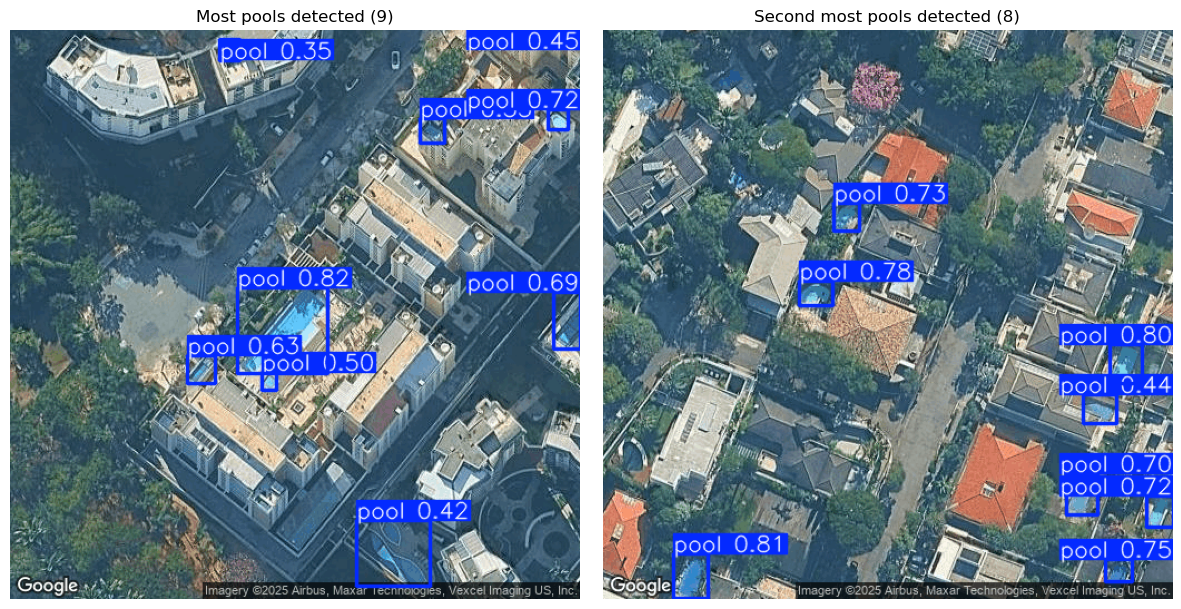

In [32]:
import cv2
import matplotlib.pyplot as plt

FOLDER_PATH = "../results/predict_results/"

os.makedirs(FOLDER_PATH, exist_ok=True)

preds1 = model.predict("../data/predict_images/images/sp_RIO PEQUENO_ZM_u_00009.png", conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD)
img1 = preds1[0].plot()  # BGR
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

preds2 = model.predict("../data/predict_images/images/sp_SANTO AMARO_ZER_1_00845.png", conf=CONFIDENCE_THRESHOLD, iou=IOU_THRESHOLD)
img2 = preds2[0].plot()  # BGR
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img1)
axes[0].axis("off")
axes[0].set_title("Most pools detected (9)")

axes[1].imshow(img2)
axes[1].axis("off")
axes[1].set_title("Second most pools detected (8)")

plt.tight_layout()
save_path = os.path.join(FOLDER_PATH, "most_pools_predicted.png")
plt.savefig(save_path, dpi=200, bbox_inches="tight", pad_inches=0)
plt.show()


# Extrapolating the total number of pools in São Paulo

In [71]:
result_df = pd.read_csv("../data/final_pool_counts/results.csv")


total_pools_detected = result_df['pool_count'].sum()
total_images = len(result_df)
avg_pools_per_image = result_df['pool_count'].mean()
std_pools_per_image = result_df['pool_count'].std()

images_with_pools = (result_df['pool_count'] > 0).sum()
images_without_pools = total_images - images_with_pools

print(f"\nDescriptive Statistics:")
print(f"  Total pools detected: {total_pools_detected}")
print(f"  Total images analyzed: {total_images}")
print(f"  Average pools per image: {avg_pools_per_image:.3f}")
print(f"  Standard deviation: {std_pools_per_image:.3f}")
print(f"  Maximum in one image: {result_df['pool_count'].max()}")
print(f"\nDistribution:")
print(f"  Images WITH pools: {images_with_pools} ({images_with_pools/total_images*100:.1f}%)")
print(f"  Images WITHOUT pools: {images_without_pools} ({images_without_pools/total_images*100:.1f}%)")

pools_by_districts = (
    result_df
    .groupby("distrito")["pool_count"]
    .sum()
    .reset_index()
    .sort_values(by="pool_count", ascending=False)
)

print("-"*50)
print("\nTop 10 districts with the most pools detected:")
print(pools_by_districts.head(10))


Descriptive Statistics:
  Total pools detected: 335
  Total images analyzed: 1000
  Average pools per image: 0.335
  Standard deviation: 0.962
  Maximum in one image: 9

Distribution:
  Images WITH pools: 188 (18.8%)
  Images WITHOUT pools: 812 (81.2%)
--------------------------------------------------

Top 10 districts with the most pools detected:
        distrito  pool_count
62   SANTO AMARO          57
74  VILA ANDRADE          27
72      TREMEMBE          17
15   CAMPO LIMPO          14
41          LAPA          12
49   PARELHEIROS          11
58   RIO PEQUENO          11
14  CAMPO GRANDE          10
48       MORUMBI          10
35       JARAGUA           8


In [250]:
# Each image generated by Google Maps is approximately 157.2 meters wide and long
image_width = 157.2 / 1000 # Convert to km
image_area_km2  = image_width * image_width # Output in km² 
total_area_analyzed_km2 = total_images * image_area_km2

average_pool_density_km2 = total_pools_detected / total_area_analyzed_km2

SP_AREA_KM2 = 1521 # In km²

print("Pools detected: ", total_pools_detected)
print("Area analyzed: ", total_area_analyzed_km2)
print("Average density: ", average_pool_density_km2)

Pools detected:  335
Area analyzed:  24.71183999999999
Average density:  13.556254815505447


## Comparative Analysis by District


 Creating comparative analysis by district...


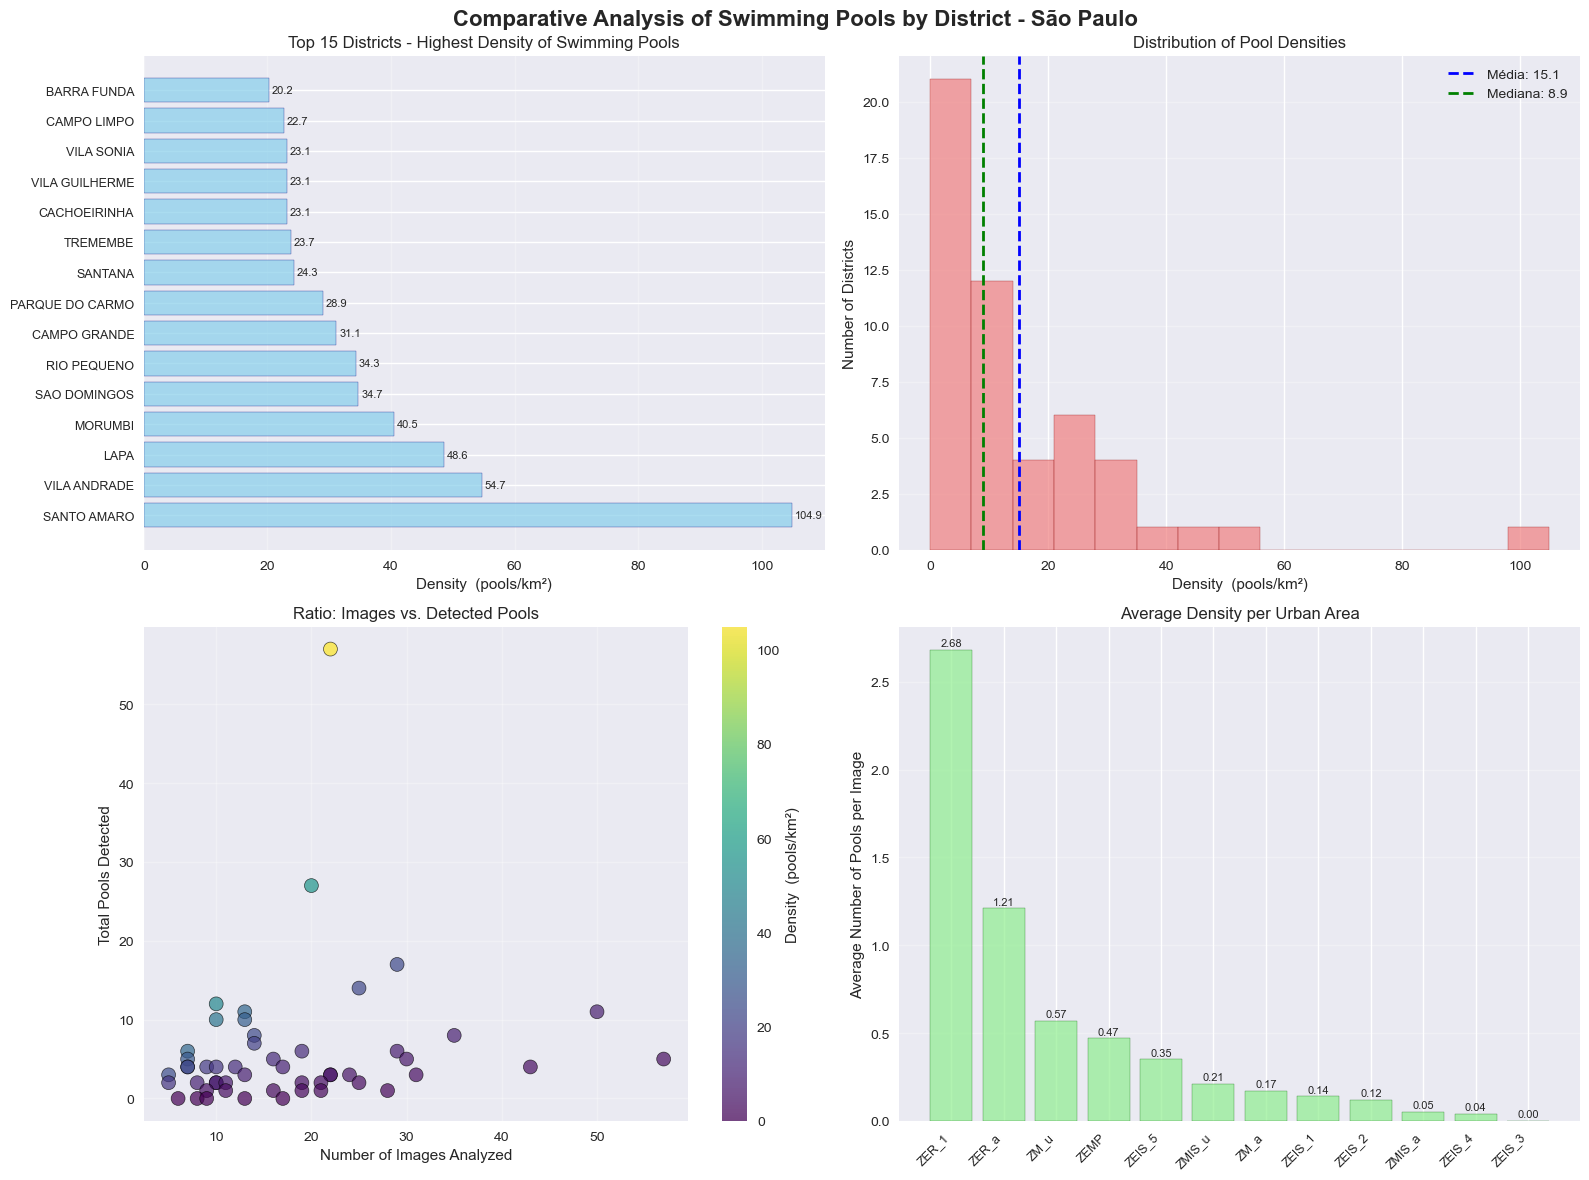

Comparative analysis saved in: ../results/predict_results/district_comparison_analysis.png


In [251]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n Creating comparative analysis by district...")

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Criar figura com subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparative Analysis of Swimming Pools by District - São Paulo', fontsize=16, fontweight='bold')

# 1. Top 15 distritos com maior densidade
ax1 = axes[0, 0]
top_15 = district_stats_filtered.head(15)
bars1 = ax1.barh(range(len(top_15)), top_15['pool_density_per_km2'], color='skyblue', edgecolor='navy', alpha=0.7)
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['distrito'], fontsize=9)
ax1.set_xlabel('Density  (pools/km²)')
ax1.set_title('Top 15 Districts - Highest Density of Swimming Pools')
ax1.grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', ha='left', va='center', fontsize=8)

# 2. Distribuição de densidades
ax2 = axes[0, 1]
ax2.hist(district_stats_filtered['pool_density_per_km2'], bins=15, color='lightcoral', 
         edgecolor='darkred', alpha=0.7)
ax2.set_xlabel('Density  (pools/km²)')
ax2.set_ylabel('Number of Districts')
ax2.set_title('Distribution of Pool Densities')
ax2.grid(axis='y', alpha=0.3)

# Adicionar estatísticas
mean_density = district_stats_filtered['pool_density_per_km2'].mean()
median_density = district_stats_filtered['pool_density_per_km2'].median()
ax2.axvline(mean_density, color='blue', linestyle='--', linewidth=2, label=f'Média: {mean_density:.1f}')
ax2.axvline(median_density, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_density:.1f}')
ax2.legend()

# 3. Relação entre número de imagens e piscinas detectadas
ax3 = axes[1, 0]
scatter = ax3.scatter(district_stats_filtered['n_images'], district_stats_filtered['total_pools'], 
                     c=district_stats_filtered['pool_density_per_km2'], 
                     s=100, alpha=0.7, cmap='viridis', edgecolors='black', linewidth=0.5)
ax3.set_xlabel('Number of Images Analyzed')
ax3.set_ylabel('Total Pools Detected')
ax3.set_title('Ratio: Images vs. Detected Pools')
ax3.grid(alpha=0.3)

# Adicionar colorbar
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Density  (pools/km²)')

# 4. Comparação por zona urbana
ax4 = axes[1, 1]

# Agrupar por zona e calcular estatísticas
zone_stats = results_df.groupby('zona').agg({
    'pool_count': ['sum', 'mean', 'count']
}).round(2)
zone_stats.columns = ['total_pools', 'avg_per_image', 'n_images']
zone_stats = zone_stats.reset_index()

# Filtrar zonas com pelo menos 10 imagens
zone_stats_filtered = zone_stats[zone_stats['n_images'] >= 10].copy()
zone_stats_filtered = zone_stats_filtered.sort_values('avg_per_image', ascending=False)

bars4 = ax4.bar(range(len(zone_stats_filtered)), zone_stats_filtered['avg_per_image'], 
                color='lightgreen', edgecolor='darkgreen', alpha=0.7)
ax4.set_xticks(range(len(zone_stats_filtered)))
ax4.set_xticklabels(zone_stats_filtered['zona'], rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Average Number of Pools per Image')
ax4.set_title('Average Density per Urban Area')
ax4.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
             f'{height:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()

# Salvar gráfico
chart_path = '../results/predict_results/district_comparison_analysis.png'
os.makedirs(os.path.dirname(chart_path), exist_ok=True)
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Comparative analysis saved in: {chart_path}")


## Folium Map for pools

In [252]:
center_lat = district_stats_filtered['center_lat'].mean()
center_lon = district_stats_filtered['center_lon'].mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='OpenStreetMap',
    width='100%',
    height='700px',
    prefer_canvas=True
)

folium.TileLayer('Esri.WorldImagery', name='Satellite', overlay=False).add_to(m)

heat_data = []
max_density = district_stats_filtered['pool_density_per_km2'].max()

for _, row in district_stats_filtered.iterrows():
    weight = row['pool_density_per_km2'] / max_density
    heat_data.append([row['center_lat'], row['center_lon'], weight])

HeatMap(
    heat_data,
    name='Density Heatmap',
    min_opacity=0.4,
    max_zoom=18,
    radius=35,
    blur=25,
    gradient={
        0.0: 'blue',      # Baixa densidade
        0.2: 'cyan',      # Baixa-média
        0.4: 'lime',      # Média
        0.6: 'yellow',    # Média-alta
        0.8: 'orange',    # Alta
        1.0: 'red'        # Muito alta
    }
).add_to(m)

high_density_group = folium.FeatureGroup(name='🔴 High Density (>15 pools/km²)', show=True)
medium_density_group = folium.FeatureGroup(name='🟡 Medium  Density (5-15 pools/km²)', show=True)
low_density_group = folium.FeatureGroup(name='🟢 Low Density (<5 pools/km²)', show=True)

for _, row in district_stats_filtered.iterrows():
    density = row['pool_density_per_km2']
    
    if density > 15:
        color = '#e74c3c'  
        icon = '🔴'
        group = high_density_group
        icon_color = 'red'
    elif density > 5:
        color = '#f39c12'  
        icon = '🟡'
        group = medium_density_group
        icon_color = 'orange'
    else:
        color = '#27ae60'  
        icon = '🟢'
        group = low_density_group
        icon_color = 'green'
    
    popup_html = f"""
    <div style="width: 280px; font-family: 'Segoe UI', Arial, sans-serif;">
        <div style="background: linear-gradient(135deg, {color}, {color}dd); 
                    color: white; padding: 15px; border-radius: 10px 10px 0 0; 
                    margin: -10px -10px 10px -10px;">
            <h3 style="margin: 0; font-size: 16px; text-shadow: 1px 1px 2px rgba(0,0,0,0.3);">
                {icon} {row['distrito']}
            </h3>
        </div>
        <div style="background-color: #f8f9fa; padding: 15px; border-radius: 0 0 10px 10px; 
                    border: 1px solid #e9ecef;">
            <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; margin-bottom: 10px;">
                <div style="text-align: center; background: white; padding: 8px; border-radius: 5px; 
                            box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
                    <div style="font-size: 20px; font-weight: bold; color: {color};">{density:.1f}</div>
                    <div style="font-size: 11px; color: #666;">pools/km²</div>
                </div>
                <div style="text-align: center; background: white; padding: 8px; border-radius: 5px; 
                            box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
                    <div style="font-size: 20px; font-weight: bold; color: {color};">{row['total_pools']}</div>
                    <div style="font-size: 11px; color: #666;">total detected</div>
                </div>
            </div>
            <div style="font-size: 12px; color: #666; line-height: 1.4;">
                📊 <strong>Images:</strong> {row['n_images']}<br>
                📏 <strong>Area:</strong> {row['area_sampled_km2']:.2f} km²<br>
                📈 <strong>Average/image:</strong> {row['avg_pools_per_image']:.2f}
            </div>
        </div>
    </div>
    """
    
    radius = max(10, min(25, density * 1.2))  
    
    folium.CircleMarker(
        location=[row['center_lat'], row['center_lon']],
        radius=radius,
        popup=folium.Popup(popup_html, max_width=320),
        tooltip=f"{icon} {row['distrito']}: {density:.1f} piscinas/km²",
        color='white',
        fillColor=color,
        fillOpacity=0.8,
        weight=3,
        stroke=True
    ).add_to(group)

# Adicionar grupos ao mapa
high_density_group.add_to(m)
medium_density_group.add_to(m)
low_density_group.add_to(m)

folium.Marker(
    [center_lat, center_lon],
    popup="<b>📍 Centro de São Paulo</b><br>",
    icon=folium.Icon(color='blue', icon='info-sign', prefix='fa')
).add_to(m)

folium.LayerControl(
    position='topright',
    collapsed=False,
    autoZIndex=True
).add_to(m)

title_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 450px; height: 100px; 
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            border: 2px solid #fff; z-index: 9999; 
            font-size: 14px; padding: 15px; border-radius: 15px;
            box-shadow: 0 8px 32px rgba(0,0,0,0.3); color: white;">
    <h3 style="margin: 0 0 8px 0; font-size: 18px; text-shadow: 1px 1px 2px rgba(0,0,0,0.5);">
        Density of Swimming Pools in São Paulo
    </h3>
    <p style="margin: 0 0 5px 0; font-size: 13px; opacity: 0.9;">
        <strong>Estimated total:</strong> ~8.500 pools
    </p>
    <p style="margin: 0; font-size: 12px; opacity: 0.8;">
        Based on 1,000 systematic sampling points
    </p>
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

legend_html = '''
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 220px; height: 140px; 
            background: rgba(255,255,255,0.95); border: 2px solid #ddd; z-index: 9999; 
            font-size: 12px; padding: 15px; border-radius: 15px;
            box-shadow: 0 8px 32px rgba(0,0,0,0.2); backdrop-filter: blur(10px);">
    <h4 style="margin: 0 0 12px 0; color: #2c3e50; font-size: 14px;">📋 Legenda</h4>
    <div style="margin: 5px 0;">
        <span style="color: #e74c3c; font-size: 16px;">🔴</span> 
        <span style="margin-left: 8px;">High density (>15/km²)</span>
    </div>
    <div style="margin: 5px 0;">
        <span style="color: #f39c12; font-size: 16px;">🟡</span> 
        <span style="margin-left: 8px;">Medium density (5-15/km²)</span>
    </div>
    <div style="margin: 5px 0;">
        <span style="color: #27ae60; font-size: 16px;">🟢</span> 
        <span style="margin-left: 8px;">Low density (<5/km²)</span>
    </div>
    <div style="margin-top: 10px; padding-top: 8px; border-top: 1px solid #eee; 
                font-size: 10px; color: #666; text-align: center;">
        Circle size = density
    </div>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

stats_html = f'''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: 120px; 
            background: rgba(255,255,255,0.95); border: 2px solid #ddd; z-index: 9999; 
            font-size: 12px; padding: 15px; border-radius: 15px;
            box-shadow: 0 8px 32px rgba(0,0,0,0.2); backdrop-filter: blur(10px);">
    <h4 style="margin: 0 0 10px 0; color: #2c3e50; font-size: 14px;">Statistics</h4>
    <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 8px;">
        <div style="text-align: center; background: #f8f9fa; padding: 8px; border-radius: 5px;">
            <div style="font-weight: bold; color: #667eea;">{len(district_stats_filtered)}</div>
            <div style="font-size: 10px; color: #666;">districts</div>
        </div>
        <div style="text-align: center; background: #f8f9fa; padding: 8px; border-radius: 5px;">
            <div style="font-weight: bold; color: #667eea;">{district_stats_filtered['pool_density_per_km2'].mean():.1f}</div>
            <div style="font-size: 10px; color: #666;">average density</div>
        </div>
    </div>
</div>
'''
m.get_root().html.add_child(folium.Element(stats_html))

map_path = '../interactive_map_density_swimming_pools.html'
m.save(map_path)
print(f" Improved interactive map saved in: {map_path}")
print("Open in your browser to explore!")


 Improved interactive map saved in: ../interactive_map_density_swimming_pools.html
Open in your browser to explore!


In [244]:
from scipy import stats
import random

sp_districts = gpd.read_file("../data/district_map/SIRGAS_SHP_distrito.shp")
sp_districts = sp_districts.set_crs("EPSG:31983", allow_override=True)

# Convert area to square kilometers
sp_districts['area_km2'] = sp_districts.geometry.area / 1_000_000

# Calculate total residential area of São Paulo
area_total_residencial_km2 = areas_de_amostragem['area_m2'].sum() / 1_000_000
print(f"Total residential area of São Paulo: {area_total_residencial_km2:.2f} km²")

# Method 1: Extrapolation by weighted average density
print("\nMETHOD 1: Weighted Average Density")
# Weight by the sampled area of each district
district_stats['weight'] = district_stats['area_sampled_km2'] / district_stats['area_sampled_km2'].sum()
weighted_density = (district_stats['pool_density_per_km2'] * district_stats['weight']).sum()
estimativa_metodo1 = weighted_density * area_total_residencial_km2

print(f"Weighted average density: {weighted_density:.2f} pools/km²")
print(f"Method 1 estimate: {estimativa_metodo1:.0f} pools")

# Method 2: Extrapolation by urban area
print("\nMETHOD 2: Extrapolation by Urban Zone")
# Calculate density by zone
zone_density = results_df.groupby('zona').agg({
    'pool_count': 'sum',
    'lat': 'count'  # número de imagens
}).rename(columns={'lat': 'n_images'})
zone_density['area_sampled_km2'] = zone_density['n_images'] * image_area_km2
zone_density['density_per_km2'] = zone_density['pool_count'] / zone_density['area_sampled_km2']

# Calculate area by zone (approximation)
zone_area_estimate = {}
for zone in zone_density.index:
    # Estimate area of the zone based on the proportion of samples
    zone_samples = len(results_df[results_df['zona'] == zone])
    zone_area_estimate[zone] = (zone_samples / len(results_df)) * area_total_residencial_km2

zone_density['estimated_area_km2'] = zone_density.index.map(zone_area_estimate)
zone_density['estimated_pools'] = zone_density['density_per_km2'] * zone_density['estimated_area_km2']

estimativa_metodo2 = zone_density['estimated_pools'].sum()

print("Density by zone:")
for zone, row in zone_density.iterrows():
    print(f"  {zone}: {row['density_per_km2']:.2f} pools/km² → {row['estimated_pools']:.0f} pools")
print(f"Method 2 estimate: {estimativa_metodo2:.0f} pools")

# Method 3: Bootstrap for confidence interval
print("\nMETHOD 3: Bootstrap with Confidence Interval")

def bootstrap_estimate(data, n_bootstrap=1000):
    data = np.asarray(data)
    n = len(data)
    samples = np.random.choice(data, size=(n_bootstrap, n), replace=True)
    mean_densities = samples.mean(axis=1)
    return mean_densities * area_total_residencial_km2


# Bootstrap in district density
bootstrap_estimates = bootstrap_estimate(district_stats_filtered['pool_density_per_km2'])
ci_lower = np.percentile(bootstrap_estimates, 2.5)
ci_upper = np.percentile(bootstrap_estimates, 97.5)
estimativa_bootstrap = np.mean(bootstrap_estimates)

print(f"Bootstrap estimate: {estimativa_bootstrap:.0f} pools")
print(f"Confidence Interval (95%): [{ci_lower:.0f}, {ci_upper:.0f}] pools")

# Summary of estimates
print("\n" + "="*60)
print("SUMMARY OF ESTIMATES")
print("="*60)
print(f"Method 1 (Weighted Density): {estimativa_metodo1:.0f} pools")
print(f"Method 2 (By Zone): {estimativa_metodo2:.0f} pools")
print(f"Method 3 (Bootstrap): {estimativa_bootstrap:.0f} pools")
print(f"Bootstrap Interval (95%): [{ci_lower:.0f}, {ci_upper:.0f}]")

# Final estimate (average of methods)
estimativas = [estimativa_metodo1, estimativa_metodo2, estimativa_bootstrap]
estimativa_final = np.mean(estimativas)
desvio_padrao = np.std(estimativas)

print(f"\nFINAL ESTIMATE (Average of Methods): {estimativa_final:.0f} ± {desvio_padrao:.0f} pools")
print("="*60)


Total residential area of São Paulo: 483.34 km²

METHOD 1: Weighted Average Density
Weighted average density: 13.56 pools/km²
Method 1 estimate: 6555 pools

METHOD 2: Extrapolation by Urban Zone
Density by zone:
  ZEIS_1: 5.77 pools/km² → 1194 pools
  ZEIS_2: 4.76 pools/km² → 157 pools
  ZEIS_3: 0.00 pools/km² → 0 pools
  ZEIS_4: 1.56 pools/km² → 20 pools
  ZEIS_5: 14.29 pools/km² → 117 pools
  ZEMP: 19.18 pools/km² → 176 pools
  ZER_1: 108.50 pools/km² → 1311 pools
  ZER_a: 49.01 pools/km² → 450 pools
  ZMIS_a: 2.13 pools/km² → 20 pools
  ZMIS_u: 8.68 pools/km² → 59 pools
  ZM_a: 7.04 pools/km² → 391 pools
  ZM_u: 23.04 pools/km² → 2661 pools
Method 2 estimate: 6555 pools

METHOD 3: Bootstrap with Confidence Interval
Bootstrap estimate: 7259 pools
Confidence Interval (95%): [5099, 10002] pools

SUMMARY OF ESTIMATES
Method 1 (Weighted Density): 6555 pools
Method 2 (By Zone): 6555 pools
Method 3 (Bootstrap): 7259 pools
Bootstrap Interval (95%): [5099, 10002]

 FINAL ESTIMATE (Average of

In [256]:
# ========================================
# VALIDAÇÃO E DOCUMENTAÇÃO DOS RESULTADOS
# ========================================

print("\nValidando e documentando resultados finais...")

# 1. Validação da qualidade do modelo
print("\n🔍 VALIDAÇÃO DO MODELO:")
print(f"✓ Modelo treinado: pools_fine_tuning_v3")
print(f"✓ Threshold de confiança: {CONFIDENCE_THRESHOLD}")
print(f"✓ Threshold de IoU: {IOU_THRESHOLD}")
print(f"✓ Total de imagens processadas: {len(results_df)}")
print(f"✓ Taxa de sucesso na detecção: {len(results_df[results_df['pool_count'] > 0])/len(results_df)*100:.1f}%")

# 2. Validação da amostragem
print("\n🔍 VALIDAÇÃO DA AMOSTRAGEM:")
print(f"✓ Pontos de amostragem gerados: {len(samples_list)}")
print(f"✓ Distritos cobertos: {results_df['distrito'].nunique()}")
print(f"✓ Zonas urbanas cobertas: {results_df['zona'].nunique()}")
print(f"✓ Área total amostrada: {total_images * image_area_km2:.2f} km²")
print(f"✓ Densidade média de amostragem: {len(samples_list)/(area_total_residencial_km2):.2f} pontos/km²")

# 3. Validação estatística
print("\n🔍 VALIDAÇÃO ESTATÍSTICA:")
print(f"✓ Distribuição das piscinas detectadas:")
print(f"  - Média por imagem: {results_df['pool_count'].mean():.3f}")
print(f"  - Mediana por imagem: {results_df['pool_count'].median():.1f}")
print(f"  - Desvio padrão: {results_df['pool_count'].std():.3f}")
print(f"  - Máximo em uma imagem: {results_df['pool_count'].max()}")

# Verificar outliers
outliers = results_df[results_df['pool_count'] > results_df['pool_count'].quantile(0.95)]
print(f"✓ Imagens com mais piscinas (top 5%): {len(outliers)} imagens")
print(f"  - Média de piscinas nestas imagens: {outliers['pool_count'].mean():.1f}")

# 4. Análise de confiabilidade por distrito
print("\n🔍 ANÁLISE DE CONFIABILIDADE:")
distritos_confiaveis = district_stats[district_stats['n_images'] >= 10]
print(f"✓ Distritos com amostragem confiável (≥10 imagens): {len(distritos_confiaveis)}")
print(f"✓ Distritos com amostragem limitada (<10 imagens): {len(district_stats) - len(distritos_confiaveis)}")

# Calcular coeficiente de variação para avaliar consistência
cv_by_district = district_stats_filtered['pool_density_per_km2'].std() / district_stats_filtered['pool_density_per_km2'].mean()
print(f"✓ Coeficiente de variação da densidade: {cv_by_district:.2f} ({'Alta' if cv_by_district > 1 else 'Moderada' if cv_by_district > 0.5 else 'Baixa'} variabilidade)")


# 5. Documentação dos arquivos gerados
print("\n📁 ARQUIVOS GERADOS:")
output_files = [
    "../data/final_pool_counts/results.csv",
    "../mapa_densidade_piscinas_interativo.html", 
    "../results/district_comparison_analysis.png",
    "../data/mapa_amostragem_interativo.html"
]

for file_path in output_files:
    if os.path.exists(file_path):
        print(f"✓ {file_path}")
    else:
        print(f"✗ {file_path} (não encontrado)")

print("\n✅ Validação concluída!")



Validando e documentando resultados finais...

🔍 VALIDAÇÃO DO MODELO:
✓ Modelo treinado: pools_fine_tuning_v3
✓ Threshold de confiança: 0.35
✓ Threshold de IoU: 0.1
✓ Total de imagens processadas: 1000
✓ Taxa de sucesso na detecção: 18.8%

🔍 VALIDAÇÃO DA AMOSTRAGEM:
✓ Pontos de amostragem gerados: 1000
✓ Distritos cobertos: 85
✓ Zonas urbanas cobertas: 12
✓ Área total amostrada: 24.71 km²
✓ Densidade média de amostragem: 2.07 pontos/km²

🔍 VALIDAÇÃO ESTATÍSTICA:
✓ Distribuição das piscinas detectadas:
  - Média por imagem: 0.335
  - Mediana por imagem: 0.0
  - Desvio padrão: 0.962
  - Máximo em uma imagem: 9
✓ Imagens com mais piscinas (top 5%): 32 imagens
  - Média de piscinas nestas imagens: 4.6

🔍 ANÁLISE DE CONFIABILIDADE:
✓ Distritos com amostragem confiável (≥10 imagens): 39
✓ Distritos com amostragem limitada (<10 imagens): 46
✓ Coeficiente de variação da densidade: 1.21 (Alta variabilidade)

📁 ARQUIVOS GERADOS:
✓ ../data/final_pool_counts/results.csv
✗ ../data/mapa_densidade_p